# Example: Gol, Lazar and Belta (2013) solved by [Bemporad Morari](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).

This example reproduces parts of the numerical results of [3]. A similar example reproducing all results of [3] is available as a codeocean capsule in [4].

This example was borrowed from [1, Example VIII.A] and tackles
an optimal control for the hybrid system with state evolution governed by
$$
x(k+1) = \begin{bmatrix} 1 & 1 \\ 0 & 1 \end{bmatrix}x(k) + \begin{bmatrix} 0.5 \\ 1.0 \end{bmatrix} u(k)
$$

The goal is to take the state vector toward a target set **XT** by visiting one of the squares
**A** or **B** and avoiding the obstacles **O1** and **O2**

First, let us import [CDDLib](https://github.com/JuliaPolyhedra/CDDLib.jl),
[GLPK](https://github.com/jump-dev/GLPK.jl), [OSQP](https://github.com/oxfordcontrol/OSQP.jl),
[JuMP](https://github.com/jump-dev/JuMP.jl), [Pavito](https://github.com/jump-dev/Pavito.jl)
and [Ipopt](https://github.com/jump-dev/Ipopt.jl)

In [1]:
import CDDLib
import GLPK
import OSQP
using JuMP
import Pavito
import HiGHS
import Ipopt

At this point we import Dionysos

In [2]:
using Dionysos
const DI = Dionysos
const UT = DI.Utils
const ST = DI.System
const OP = DI.Optim

Dionysos.Optim

And the file defining the hybrid system for this problem

In [3]:
include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "gol_lazar_belta.jl"))

Main.var"##597".GolLazarBelta

Now we instantiate our optimal control problem using the function provided by [GolLazarBelta.jl](https://github.com/dionysos-dev/Dionysos.jl/blob/master/problems/GolLazarBelta.jl)

In [4]:
problem = GolLazarBelta.problem(CDDLib.Library(), Float64);

Finally, we select the method presented in [2] as our optimizer

In [5]:
qp_solver = optimizer_with_attributes(
    OSQP.Optimizer,
    "eps_abs" => 1e-8,
    "eps_rel" => 1e-8,
    "max_iter" => 100000,
    MOI.Silent() => true,
);

mip_solver = optimizer_with_attributes(HiGHS.Optimizer, MOI.Silent() => true);

cont_solver = optimizer_with_attributes(Ipopt.Optimizer, MOI.Silent() => true);

miqp_solver = optimizer_with_attributes(
    Pavito.Optimizer,
    "mip_solver" => mip_solver,
    "cont_solver" => cont_solver,
    MOI.Silent() => true,
);

algo = optimizer_with_attributes(
    OP.BemporadMorari.Optimizer{Float64},
    "continuous_solver" => qp_solver,
    "mixed_integer_solver" => miqp_solver,
    "indicator" => false,
    "log_level" => 0,
);

and use it to solve the given problem, with the help of the abstraction layer
MathOptInterface provided by [JuMP](https://github.com/jump-dev/JuMP.jl)

In [6]:
optimizer = MOI.instantiate(algo)
MOI.set(optimizer, MOI.RawOptimizerAttribute("problem"), problem)
MOI.optimize!(optimizer)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

┌ Warning: Infeasible NLP problem terminated with primal status: NEARLY_FEASIBLE_POINT
└ @ Pavito ~/.julia/packages/Pavito/BWPfc/src/optimize.jl:701
┌ Warning: Infeasible NLP problem terminated with primal status: NEARLY_FEASIBLE_POINT
└ @ Pavito ~/.julia/packages/Pavito/BWPfc/src/optimize.jl:701


19.988291025161743

We check the solver time

In [7]:
MOI.get(optimizer, MOI.SolveTimeSec())

19.988291025161743

the termination status

In [8]:
termination = MOI.get(optimizer, MOI.TerminationStatus())

LOCALLY_SOLVED::TerminationStatusCode = 4

the objective value

In [9]:
objective_value = MOI.get(optimizer, MOI.ObjectiveValue())

11.385062952226304

and recover the corresponding continuous trajectory

In [10]:
xu = MOI.get(optimizer, ST.ContinuousTrajectoryAttribute());

## A little bit of data visualization now:

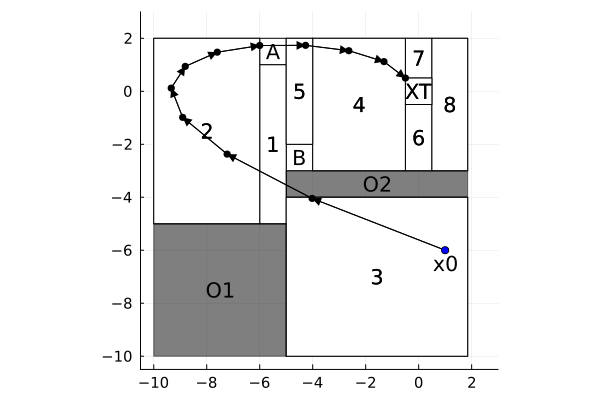

In [11]:
using Plots
using Polyhedra
using HybridSystems
using Suppressor

#Initialize our canvas
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
xlims!(-10.5, 3.0)
ylims!(-10.5, 3.0)

#Plot the discrete modes
for mode in states(problem.system)
    t =
        (problem.system.ext[:q_T] in [mode, mode + 11]) ? "XT" :
        (
            mode == problem.system.ext[:q_A] ? "A" :
            (
                mode == problem.system.ext[:q_B] ? "B" :
                mode <= 11 ? string(mode) : string(mode - 11)
            )
        )
    set = stateset(problem.system, mode)
    plot!(set; color = :white)
    UT.text_in_set_plot!(fig, set, t)
end

#Plot obstacles
for i in eachindex(problem.system.ext[:obstacles])
    set = problem.system.ext[:obstacles][i]
    plot!(set; color = :black, opacity = 0.5)
    UT.text_in_set_plot!(fig, set, "O$i")
end

#Plot trajectory
x0 = problem.initial_set[2]
x_traj = [x0, xu.x...]
plot!(fig, UT.DrawTrajectory(x_traj));

#Plot initial point
plot!(fig, UT.DrawPoint(x0); color = :blue)
annotate!(fig, x0[1], x0[2] - 0.5, "x0")

### References

1. Gol, E. A., Lazar, M., & Belta, C. (2013). Language-guided controller synthesis for linear systems. IEEE Transactions on Automatic Control, 59(5), 1163-1176.
1. Bemporad, A., & Morari, M. (1999). Control of systems integrating logic, dynamics, and constraints. Automatica, 35(3), 407-427.
1. Legat B., Bouchat J., Jungers R. M. (2021). Abstraction-based branch and bound approach to Q-learning for hybrid optimal control. 3rd Annual Learning for Dynamics & Control Conference, 2021.
1. Legat B., Bouchat J., Jungers R. M. (2021). Abstraction-based branch and bound approach to Q-learning for hybrid optimal control. https://www.codeocean.com/. https://doi.org/10.24433/CO.6650697.v1.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*